In [70]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [2]:
# import preprocessed data
defensive_players = pd.read_csv('defensive_players.csv')

# Baseline

### No tackles

In [3]:
# Take number of no tackles / total number of players (predict 0 for everyone)
baseline_table = defensive_players['tackle_prob'].value_counts()
baseline_acc = baseline_table[0] / (baseline_table[0] + baseline_table[1])

print(f"Baseline of predicting no tackles is: {baseline_acc}")

# randomly would do worse than this

Baseline of predicting no tackles is: 0.9225635004017056


### Random tackle per play

In [4]:
# Group by playId and gameId and randomly predict player to make tackle
baseline_predictions = defensive_players.groupby(['gameId', 'playId']).apply(lambda group: group.sample(n=1)).copy()

# Create a new column 'tackle_prob' and set it to 1 for the sampled rows
baseline_predictions['tackle_pred'] = 1

# Reset index to remove hierarchical index
baseline_predictions_reset = baseline_predictions.reset_index(drop=True)

# Create a new DataFrame with all rows from defensive_players and merge with baseline_predictions_reset
all_rows = defensive_players.merge(baseline_predictions_reset[['gameId', 'playId', 'nflId_defense', 'tackle_pred']], on=['gameId', 'playId', 'nflId_defense'], how='left')

# Fill NaN values with 0 in the tackle_prob column
all_rows['tackle_pred'].fillna(0, inplace=True)
all_rows[['gameId', 'playId', 'nflId_defense', 'tackle_prob', 'tackle_pred']]

,gameId,playId,nflId_defense,tackle_prob,tackle_pred
0,2022090800,56,38577.0,0,0.0
1,2022090800,56,41239.0,0,0.0
2,2022090800,56,42816.0,0,0.0
3,2022090800,56,43294.0,1,0.0
4,2022090800,56,43298.0,0,1.0
...,...,...,...,...,...
48538,2022091200,3826,43436.0,0,0.0
48539,2022091200,3826,42827.0,0,1.0
48540,2022091200,3826,44873.0,0,0.0
48541,2022091200,3826,54505.0,0,0.0


In [6]:
# Confusion matrix
conf_matrix_baseline = confusion_matrix(all_rows['tackle_prob'], all_rows['tackle_pred'])

# Display the confusion matrix
print("Confusion Matrix for Baseline:")
print(conf_matrix_baseline)

baseline_acc = (conf_matrix_baseline[0,0] + conf_matrix_baseline[1,1]) / (conf_matrix_baseline[0,0] + conf_matrix_baseline[0,1] + conf_matrix_baseline[1,0] + conf_matrix_baseline[1,1])

print(f"Baseline of predicting random tackles is: {baseline_acc}")

# Compute AUC
auc_roc = roc_auc_score(all_rows['tackle_prob'], all_rows['tackle_pred'])

# Displaying the results
print(f"AUC is: {auc_roc:.2f}")

Confusion Matrix for Baseline:
[[40673  4111]
 [ 3457   302]]
Baseline of predicting random tackles is: 0.8440969861772037
AUC is: 0.49


# Feature Selection

### Remove columns - domain knowledge

In [3]:
# Columns to be removed
columns_to_remove = [
    'gameId', 'playId', 'frameId', 'time', 'event', 'season', 'club', 
    'gameDate', 'gameTimeEastern','gameClock','nflId_defense', 'nflId_offense', 
     'defensiveTeam',
    
    'homeFinalScore', 'visitorFinalScore', 'preSnapHomeScore', 'preSnapVisitorScore',
    'homeTeamAbbr', 'visitorTeamAbbr',
    
    'displayName_y','ballCarrierDisplayName','ballCarrierId', 'displayName_x_offense', 
    'displayName_x_defense','position_defense', 'position_role_defense', 
    'position_offense', 'position_role_offense',
    
    'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability', 'tackle','prob_differential',
    'offense_win_prob', 'differential', 'is_defense','x_offense', 'x_defense','y_offense', 'y_defense',
    'dis_offense', 'dis_defense','passProbability', 'absoluteYardlineNumber',
    
    'game_rolling_missed_tackle_ct','season_rolling_missed_tackle_ct', 'game_rolling_tackle_ct', 
    'season_rolling_tackle_ct'
]

# Drop columns
defensive_players_filtered = defensive_players.drop(columns=columns_to_remove, errors='ignore')
defensive_players_filtered

# nflId_defense, nflId_offense, playDirection, week, position_group_defense, quarter, down, absoluteYardlineNumber, offenseFormation, defensiveTeam, position_offense

,playDirection,s_defense,a_defense,o_defense,dir_defense,week,height_in_inch_defense,weight_defense,position_group_defense,quarter,down,yardsToGo,time_remaining,passLength,offenseFormation,defendersInTheBox,assist,forcedFumble,pff_missedTackle,s_offense,a_offense,o_offense,dir_offense,weight_offense,height_in_inch_offense,position_group_offense,offense_score,defense_score,defense_win_prob,dist_to_bc,rank_to_bc,tackle_prob
0,left,3.35,2.62,349.47,357.71,1,72,242,LB,1,1,10,3600,5.0,SHOTGUN,6.0,0.0,0.0,0.0,4.61,4.82,114.27,202.20,191,72,R,0,0,0.413347,7.067538,3.0,0
1,left,3.62,2.86,186.16,157.65,1,73,280,DL,1,1,10,3600,5.0,SHOTGUN,6.0,0.0,0.0,0.0,4.61,4.82,114.27,202.20,191,72,R,0,0,0.413347,13.527265,9.0,0
2,left,2.60,4.14,331.57,278.33,1,71,184,DB,1,1,10,3600,5.0,SHOTGUN,6.0,0.0,0.0,0.0,4.61,4.82,114.27,202.20,191,72,R,0,0,0.413347,29.415605,11.0,0
3,left,5.88,1.23,140.96,178.50,1,73,208,DB,1,1,10,3600,5.0,SHOTGUN,6.0,0.0,0.0,0.0,4.61,4.82,114.27,202.20,191,72,R,0,0,0.413347,2.828003,1.0,1
4,left,1.34,2.21,159.12,203.53,1,77,240,DL,1,1,10,3600,5.0,SHOTGUN,6.0,0.0,0.0,0.0,4.61,4.82,114.27,202.20,191,72,R,0,0,0.413347,12.502404,6.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48538,left,3.50,0.92,112.81,184.46,1,76,291,DL,4,3,14,71,-6.0,SHOTGUN,3.0,0.0,0.0,0.0,3.91,2.22,313.03,192.49,220,70,HB,16,17,0.508994,16.352676,4.0,0
48539,left,6.30,2.68,103.59,136.76,1,71,190,DB,4,3,14,71,-6.0,SHOTGUN,3.0,0.0,0.0,1.0,3.91,2.22,313.03,192.49,220,70,HB,16,17,0.508994,9.983927,1.0,0
48540,left,4.63,4.05,143.62,159.31,1,74,220,DB,4,3,14,71,-6.0,SHOTGUN,3.0,0.0,0.0,0.0,3.91,2.22,313.03,192.49,220,70,HB,16,17,0.508994,29.283342,8.0,0
48541,left,4.80,3.11,183.52,187.27,1,76,265,LB,4,3,14,71,-6.0,SHOTGUN,3.0,0.0,0.0,0.0,3.91,2.22,313.03,192.49,220,70,HB,16,17,0.508994,13.167270,2.0,0


### Create composite values

In [189]:
# # Create new columns for composite features
# defensive_players_filtered['height_dif'] = defensive_players_filtered['height_in_inch_defense'] - defensive_players_filtered['height_in_inch_offense']
# defensive_players_filtered['s_dif'] = defensive_players_filtered['s_defense'] - defensive_players_filtered['s_offense']
# defensive_players_filtered['dis_dif'] = defensive_players_filtered['dis_defense'] - defensive_players_filtered['dis_offense']
# defensive_players_filtered['weight_dif'] = defensive_players_filtered['weight_offense'] - defensive_players_filtered['weight_defense']

# # Drop the columns used to create the composite features
# columns_to_drop = ['height_in_inch_defense', 'height_in_inch_offense',
#                    's_defense', 's_offense',
#                    'dis_defense', 'dis_offense',
#                    'weight_offense', 'weight_defense']

# defensive_players_filtered_comp = defensive_players_filtered.drop(columns=columns_to_drop, axis=1)
# defensive_players_filtered_comp

In [139]:
defensive_players_filtered

,playDirection,s_defense,a_defense,o_defense,dir_defense,week,height_in_inch_defense,weight_defense,position_group_defense,quarter,down,yardsToGo,time_remaining,passLength,offenseFormation,defendersInTheBox,assist,forcedFumble,pff_missedTackle,s_offense,a_offense,o_offense,dir_offense,weight_offense,height_in_inch_offense,position_group_offense,offense_score,defense_score,defense_win_prob,dist_to_bc,rank_to_bc,tackle_prob
0,left,3.35,2.62,349.47,357.71,1,72,242,LB,1,1,10,3600,5.0,SHOTGUN,6.0,0.0,0.0,0.0,4.61,4.82,114.27,202.20,191,72,R,0,0,0.413347,7.067538,3.0,0
1,left,3.62,2.86,186.16,157.65,1,73,280,DL,1,1,10,3600,5.0,SHOTGUN,6.0,0.0,0.0,0.0,4.61,4.82,114.27,202.20,191,72,R,0,0,0.413347,13.527265,9.0,0
2,left,2.60,4.14,331.57,278.33,1,71,184,DB,1,1,10,3600,5.0,SHOTGUN,6.0,0.0,0.0,0.0,4.61,4.82,114.27,202.20,191,72,R,0,0,0.413347,29.415605,11.0,0
3,left,5.88,1.23,140.96,178.50,1,73,208,DB,1,1,10,3600,5.0,SHOTGUN,6.0,0.0,0.0,0.0,4.61,4.82,114.27,202.20,191,72,R,0,0,0.413347,2.828003,1.0,1
4,left,1.34,2.21,159.12,203.53,1,77,240,DL,1,1,10,3600,5.0,SHOTGUN,6.0,0.0,0.0,0.0,4.61,4.82,114.27,202.20,191,72,R,0,0,0.413347,12.502404,6.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48538,left,3.50,0.92,112.81,184.46,1,76,291,DL,4,3,14,71,-6.0,SHOTGUN,3.0,0.0,0.0,0.0,3.91,2.22,313.03,192.49,220,70,HB,16,17,0.508994,16.352676,4.0,0
48539,left,6.30,2.68,103.59,136.76,1,71,190,DB,4,3,14,71,-6.0,SHOTGUN,3.0,0.0,0.0,1.0,3.91,2.22,313.03,192.49,220,70,HB,16,17,0.508994,9.983927,1.0,0
48540,left,4.63,4.05,143.62,159.31,1,74,220,DB,4,3,14,71,-6.0,SHOTGUN,3.0,0.0,0.0,0.0,3.91,2.22,313.03,192.49,220,70,HB,16,17,0.508994,29.283342,8.0,0
48541,left,4.80,3.11,183.52,187.27,1,76,265,LB,4,3,14,71,-6.0,SHOTGUN,3.0,0.0,0.0,0.0,3.91,2.22,313.03,192.49,220,70,HB,16,17,0.508994,13.167270,2.0,0


### One-hot encoding

In [4]:
columns_to_one_hot_encode = [
    'playDirection', 'position_group_offense',
    'position_group_defense', 'quarter', 'down',
    'offenseFormation'
]

# One-hot encoding
defensive_players_encoded = pd.get_dummies(defensive_players_filtered, columns=columns_to_one_hot_encode)
defensive_players_encoded

,s_defense,a_defense,o_defense,dir_defense,week,height_in_inch_defense,weight_defense,yardsToGo,time_remaining,passLength,defendersInTheBox,assist,forcedFumble,pff_missedTackle,s_offense,a_offense,o_offense,dir_offense,weight_offense,height_in_inch_offense,offense_score,defense_score,defense_win_prob,dist_to_bc,rank_to_bc,tackle_prob,playDirection_left,playDirection_right,position_group_offense_HB,position_group_offense_QB,position_group_offense_R,position_group_defense_DB,position_group_defense_DL,position_group_defense_LB,quarter_1,quarter_2,quarter_3,quarter_4,quarter_5,down_1,down_2,down_3,down_4,offenseFormation_EMPTY,offenseFormation_I_FORM,offenseFormation_JUMBO,offenseFormation_PISTOL,offenseFormation_SHOTGUN,offenseFormation_SINGLEBACK,offenseFormation_WILDCAT
0,3.35,2.62,349.47,357.71,1,72,242,10,3600,5.0,6.0,0.0,0.0,0.0,4.61,4.82,114.27,202.20,191,72,0,0,0.413347,7.067538,3.0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,3.62,2.86,186.16,157.65,1,73,280,10,3600,5.0,6.0,0.0,0.0,0.0,4.61,4.82,114.27,202.20,191,72,0,0,0.413347,13.527265,9.0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,2.60,4.14,331.57,278.33,1,71,184,10,3600,5.0,6.0,0.0,0.0,0.0,4.61,4.82,114.27,202.20,191,72,0,0,0.413347,29.415605,11.0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,5.88,1.23,140.96,178.50,1,73,208,10,3600,5.0,6.0,0.0,0.0,0.0,4.61,4.82,114.27,202.20,191,72,0,0,0.413347,2.828003,1.0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,1.34,2.21,159.12,203.53,1,77,240,10,3600,5.0,6.0,0.0,0.0,0.0,4.61,4.82,114.27,202.20,191,72,0,0,0.413347,12.502404,6.0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48538,3.50,0.92,112.81,184.46,1,76,291,14,71,-6.0,3.0,0.0,0.0,0.0,3.91,2.22,313.03,192.49,220,70,16,17,0.508994,16.352676,4.0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
48539,6.30,2.68,103.59,136.76,1,71,190,14,71,-6.0,3.0,0.0,0.0,1.0,3.91,2.22,313.03,192.49,220,70,16,17,0.508994,9.983927,1.0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
48540,4.63,4.05,143.62,159.31,1,74,220,14,71,-6.0,3.0,0.0,0.0,0.0,3.91,2.22,313.03,192.49,220,70,16,17,0.508994,29.283342,8.0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
48541,4.80,3.11,183.52,187.27,1,76,265,14,71,-6.0,3.0,0.0,0.0,0.0,3.91,2.22,313.03,192.49,220,70,16,17,0.508994,13.167270,2.0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0


In [5]:
total = 0
col_count = len(columns_to_one_hot_encode)
for col in columns_to_one_hot_encode:
    unique_values_count = len(defensive_players_filtered[col].unique())
    print(f"There are {unique_values_count} unique values for {col}")
    total = total + unique_values_count
print(f"Adding {total - col_count} columns")

There are 2 unique values for playDirection
There are 3 unique values for position_group_offense
There are 3 unique values for position_group_defense
There are 5 unique values for quarter
There are 4 unique values for down
There are 7 unique values for offenseFormation
Adding 18 columns


### Multi-collinearity

In [146]:
# Remove categorical columns to look at correlation
defensive_players_correlation = defensive_players_filtered.drop(columns=columns_to_one_hot_encode, errors='ignore')

# See if any non-numeric columns left
non_numeric_columns = defensive_players_correlation.select_dtypes(exclude=['number']).columns

print("Non-Numeric Columns:")
print(non_numeric_columns)

Non-Numeric Columns:
Index([], dtype='object')


In [11]:
# CORRELATION MATRIX

correlation_matrix = defensive_players_correlation.corr()

# Set your threshold
correlation_threshold = 0.6

# Filter the correlation matrix based on the threshold
high_correlation = correlation_matrix[(correlation_matrix > correlation_threshold) | (correlation_matrix < -correlation_threshold)]

# Display the filtered correlation matrix
print("Correlation Matrix - High Correlation:")
high_correlation

Correlation Matrix - High Correlation:


,s_defense,a_defense,o_defense,dir_defense,week,height_in_inch_defense,weight_defense,yardsToGo,time_remaining,passLength,defendersInTheBox,assist,forcedFumble,pff_missedTackle,s_offense,a_offense,o_offense,dir_offense,weight_offense,height_in_inch_offense,offense_score,defense_score,defense_win_prob,dist_to_bc,rank_to_bc,tackle_prob
s_defense,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a_defense,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
o_defense,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dir_defense,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
week,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
height_in_inch_defense,NaN,NaN,NaN,NaN,NaN,1.000000,0.701818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weight_defense,NaN,NaN,NaN,NaN,NaN,0.701818,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yardsToGo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time_remaining,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.66595,-0.742167,NaN,NaN,NaN,NaN
passLength,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# VIF

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = defensive_players_correlation.columns
vif_data["VIF"] = [variance_inflation_factor(defensive_players_correlation.values, i) for i in range(defensive_players_correlation.shape[1])]
vif_data_sorted = vif_data.sort_values(by='VIF', ascending=False)

print("\nVariance Inflation Factor (VIF):")
print(vif_data_sorted)


Variance Inflation Factor (VIF):
                   Feature         VIF
19  height_in_inch_offense  980.583607
5   height_in_inch_defense  843.162786
18          weight_offense  155.520528
6           weight_defense   67.045514
10       defendersInTheBox   46.039049
22        defense_win_prob   21.981795
21           defense_score   16.463757
24              rank_to_bc   16.354524
23              dist_to_bc   14.907030
20           offense_score   11.190380
8           time_remaining   10.929187
14               s_offense    7.528097
0                s_defense    6.998225
7                yardsToGo    6.342259
1                a_defense    5.331054
15               a_offense    5.200428
4                     week    4.895867
3              dir_defense    4.380482
2                o_defense    4.245608
16               o_offense    3.990183
17             dir_offense    3.756067
9               passLength    1.912787
25             tackle_prob    1.358157
11                  assist    

### Finalize Selected Data

In [6]:
selected_data = defensive_players_encoded
selected_data

,s_defense,a_defense,o_defense,dir_defense,week,height_in_inch_defense,weight_defense,yardsToGo,time_remaining,passLength,defendersInTheBox,assist,forcedFumble,pff_missedTackle,s_offense,a_offense,o_offense,dir_offense,weight_offense,height_in_inch_offense,offense_score,defense_score,defense_win_prob,dist_to_bc,rank_to_bc,tackle_prob,playDirection_left,playDirection_right,position_group_offense_HB,position_group_offense_QB,position_group_offense_R,position_group_defense_DB,position_group_defense_DL,position_group_defense_LB,quarter_1,quarter_2,quarter_3,quarter_4,quarter_5,down_1,down_2,down_3,down_4,offenseFormation_EMPTY,offenseFormation_I_FORM,offenseFormation_JUMBO,offenseFormation_PISTOL,offenseFormation_SHOTGUN,offenseFormation_SINGLEBACK,offenseFormation_WILDCAT
0,3.35,2.62,349.47,357.71,1,72,242,10,3600,5.0,6.0,0.0,0.0,0.0,4.61,4.82,114.27,202.20,191,72,0,0,0.413347,7.067538,3.0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,3.62,2.86,186.16,157.65,1,73,280,10,3600,5.0,6.0,0.0,0.0,0.0,4.61,4.82,114.27,202.20,191,72,0,0,0.413347,13.527265,9.0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,2.60,4.14,331.57,278.33,1,71,184,10,3600,5.0,6.0,0.0,0.0,0.0,4.61,4.82,114.27,202.20,191,72,0,0,0.413347,29.415605,11.0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,5.88,1.23,140.96,178.50,1,73,208,10,3600,5.0,6.0,0.0,0.0,0.0,4.61,4.82,114.27,202.20,191,72,0,0,0.413347,2.828003,1.0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,1.34,2.21,159.12,203.53,1,77,240,10,3600,5.0,6.0,0.0,0.0,0.0,4.61,4.82,114.27,202.20,191,72,0,0,0.413347,12.502404,6.0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48538,3.50,0.92,112.81,184.46,1,76,291,14,71,-6.0,3.0,0.0,0.0,0.0,3.91,2.22,313.03,192.49,220,70,16,17,0.508994,16.352676,4.0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
48539,6.30,2.68,103.59,136.76,1,71,190,14,71,-6.0,3.0,0.0,0.0,1.0,3.91,2.22,313.03,192.49,220,70,16,17,0.508994,9.983927,1.0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
48540,4.63,4.05,143.62,159.31,1,74,220,14,71,-6.0,3.0,0.0,0.0,0.0,3.91,2.22,313.03,192.49,220,70,16,17,0.508994,29.283342,8.0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
48541,4.80,3.11,183.52,187.27,1,76,265,14,71,-6.0,3.0,0.0,0.0,0.0,3.91,2.22,313.03,192.49,220,70,16,17,0.508994,13.167270,2.0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0


In [48]:
# # Selecting the numerical features and target variable
# selected_num_features=['playId','gameId','x_defense',
#        'y_defense', 's_defense', 'a_defense', 'dis_defense', 'o_defense',
#        'dir_defense', 'week',
#        'height_in_inch_defense', 'weight_defense', 'quarter',
#        'down', 'yardsToGo', 'time_remaining', 'absoluteYardlineNumber',
#         'passLength',
#        'defendersInTheBox', 'passProbability',  'season_rolling_tackle_ct',
#        'game_rolling_tackle_ct', 'season_rolling_missed_tackle_ct',
#        'game_rolling_missed_tackle_ct', 'x_offense', 'y_offense', 's_offense',
#        'a_offense', 'dis_offense', 'o_offense', 'dir_offense',
#        'weight_offense', 'height_in_inch_offense',
#        'offense_score', 'defense_score', 'differential', 'dist_to_bc',
#        'rank_to_bc', 'is_defense',
#         'offense_win_prob', 'defense_win_prob', 'prob_differential']

# target = 'tackle_prob'

# # Creating a new DataFrame with only the selected numerical features and target
# selected_data = defensive_players[selected_num_features + [target]].copy()
# selected_data

# EDA

In [14]:
# Count number of tackles in dataset
tackle_number = selected_data['tackle_prob'].value_counts()

# Count number of tackles per game
game_id = defensive_players['gameId']
selected_data_id = pd.concat([selected_data, game_id], axis=1)

game_tackles = selected_data_id[selected_data_id['tackle_prob'] == 1].groupby('gameId')['tackle_prob'].sum()

average_game_tackles = game_tackles.mean()

# Count number of tackles per week
weekly_tackles = selected_data_id[selected_data_id['tackle_prob'] == 1].groupby('week')['tackle_prob'].sum()

print("Number of tackles in dataset:")
print(tackle_number)

print("\nAverage number of tackles per game:")
print(average_game_tackles)

print("\nNumber of tackles by week:")
print(weekly_tackles)


Number of tackles in dataset:
0    44784
1     3759
Name: tackle_prob, dtype: int64

Average number of tackles per game:
34.80555555555556

Number of tackles by week:
week
1    584
2    533
3    596
4    486
5    582
6    480
7    498
Name: tackle_prob, dtype: int64


In [15]:
# Tackles by defensive position
def_pos_tackles_all = defensive_players.groupby('position_defense')['tackle_prob'].sum().reset_index()
def_pos_tackles_role = defensive_players.groupby('position_role_defense')['tackle_prob'].sum().reset_index()
def_pos_tackles_group = defensive_players.groupby('position_group_defense')['tackle_prob'].sum().reset_index()

# Display the result
print("Number of tackles per position - ALL")
print(def_pos_tackles_all)
print("Number of tackles per position - ROLE")
print(def_pos_tackles_role)
print("Number of tackles per position - GROUP")
print(def_pos_tackles_group)


Number of tackles per position - ALL
  position_defense  tackle_prob
0               CB         1492
1               DB           14
2               DE           55
3               DT           47
4               FS          553
5              ILB          663
6              MLB           52
7               NT            9
8              OLB          359
9               SS          515
Number of tackles per position - ROLE
  position_role_defense  tackle_prob
0                    CB         1492
1                    DB         1082
2                    DL           56
3                  EDGE          414
4                    LB          715
Number of tackles per position - GROUP
  position_group_defense  tackle_prob
0                     DB         2574
1                     DL          111
2                     LB         1074


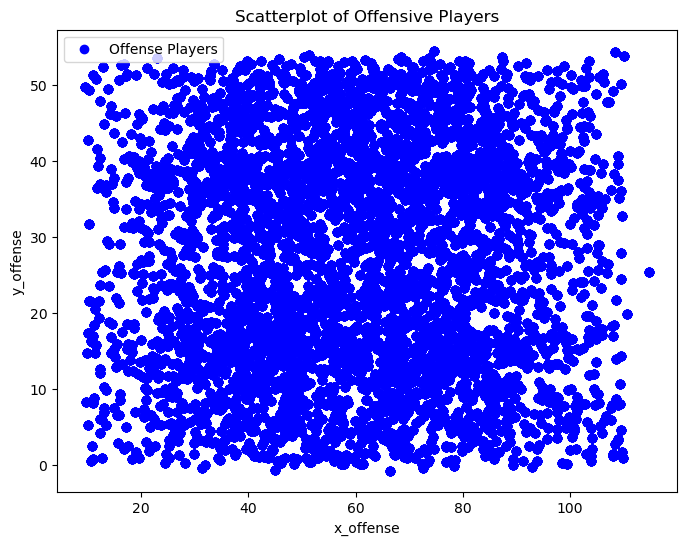

In [75]:
# Display all x_offense, y_offense
# Scatterplot 1: Displaying all x_offense, y_offense
plt.figure(figsize=(8, 6))
plt.scatter(defensive_players['x_offense'], defensive_players['y_offense'], c='blue', label='Offense Players')
plt.title('Scatterplot of Offensive Players')
plt.xlabel('x_offense')
plt.ylabel('y_offense')
plt.legend()
plt.show()

In [87]:
print(defensive_players[['x_offense','y_offense']].value_counts())
len(defensive_players[(defensive_players['x_offense']==84.88)&(defensive_players['y_offense']==7.19)])


x_offense  y_offense
84.88      7.19         22
87.58      10.39        22
71.25      45.31        11
71.32      9.60         11
71.31      42.89        11
                        ..
48.61      10.33        11
48.62      0.13         11
           19.59        11
           37.61        11
114.73     25.36        11
Length: 4411, dtype: int64


22

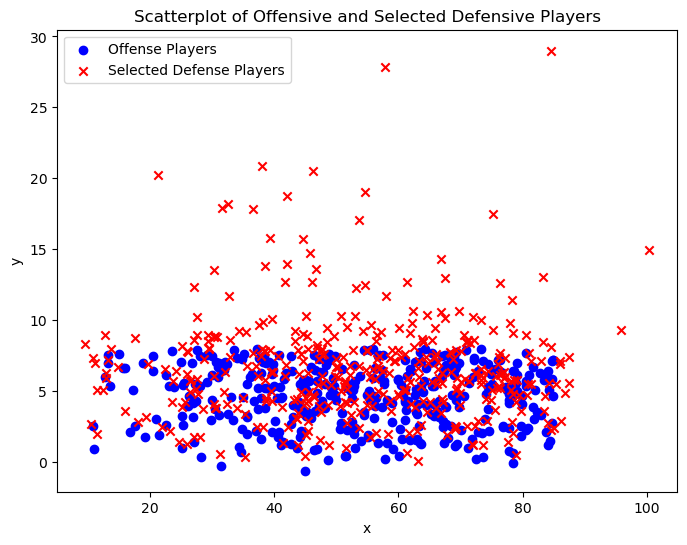

In [93]:
# Scatterplot 2: Selecting a specific x_offense, y_offense
selected_x_offense = 85 # 84.88
selected_y_offense = 8 # 7.19

selected_defense = defensive_players[(defensive_players['x_offense'] < selected_x_offense) 
                                     & (defensive_players['y_offense'] < selected_y_offense)
                                     & (defensive_players['tackle_prob'] == 1)]

plt.figure(figsize=(8, 6))
plt.scatter(selected_defense['x_offense'], selected_defense['y_offense'], c='blue', label='Offense Players')
plt.scatter(selected_defense['x_defense'], selected_defense['y_defense'], c='red', label='Selected Defense Players', marker='x')
plt.title('Scatterplot of Offensive and Selected Defensive Players')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

# Modeling

## Logistic Regression

In [158]:
selected_data

,s_defense,a_defense,o_defense,dir_defense,week,height_in_inch_defense,weight_defense,yardsToGo,time_remaining,passLength,defendersInTheBox,assist,forcedFumble,pff_missedTackle,s_offense,a_offense,o_offense,dir_offense,weight_offense,height_in_inch_offense,offense_score,defense_score,defense_win_prob,dist_to_bc,rank_to_bc,tackle_prob,playDirection_left,playDirection_right,position_group_offense_HB,position_group_offense_QB,position_group_offense_R,position_group_defense_DB,position_group_defense_DL,position_group_defense_LB,quarter_1,quarter_2,quarter_3,quarter_4,quarter_5,down_1,down_2,down_3,down_4,offenseFormation_EMPTY,offenseFormation_I_FORM,offenseFormation_JUMBO,offenseFormation_PISTOL,offenseFormation_SHOTGUN,offenseFormation_SINGLEBACK,offenseFormation_WILDCAT
0,3.35,2.62,349.47,357.71,1,72,242,10,3600,5.0,6.0,0.0,0.0,0.0,4.61,4.82,114.27,202.20,191,72,0,0,0.413347,7.067538,3.0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,3.62,2.86,186.16,157.65,1,73,280,10,3600,5.0,6.0,0.0,0.0,0.0,4.61,4.82,114.27,202.20,191,72,0,0,0.413347,13.527265,9.0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,2.60,4.14,331.57,278.33,1,71,184,10,3600,5.0,6.0,0.0,0.0,0.0,4.61,4.82,114.27,202.20,191,72,0,0,0.413347,29.415605,11.0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,5.88,1.23,140.96,178.50,1,73,208,10,3600,5.0,6.0,0.0,0.0,0.0,4.61,4.82,114.27,202.20,191,72,0,0,0.413347,2.828003,1.0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,1.34,2.21,159.12,203.53,1,77,240,10,3600,5.0,6.0,0.0,0.0,0.0,4.61,4.82,114.27,202.20,191,72,0,0,0.413347,12.502404,6.0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48538,3.50,0.92,112.81,184.46,1,76,291,14,71,-6.0,3.0,0.0,0.0,0.0,3.91,2.22,313.03,192.49,220,70,16,17,0.508994,16.352676,4.0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
48539,6.30,2.68,103.59,136.76,1,71,190,14,71,-6.0,3.0,0.0,0.0,1.0,3.91,2.22,313.03,192.49,220,70,16,17,0.508994,9.983927,1.0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
48540,4.63,4.05,143.62,159.31,1,74,220,14,71,-6.0,3.0,0.0,0.0,0.0,3.91,2.22,313.03,192.49,220,70,16,17,0.508994,29.283342,8.0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
48541,4.80,3.11,183.52,187.27,1,76,265,14,71,-6.0,3.0,0.0,0.0,0.0,3.91,2.22,313.03,192.49,220,70,16,17,0.508994,13.167270,2.0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0


In [98]:
# Handling missing values if any
selected_data.dropna(inplace=True)
#understand which na values are being dropped

# Splitting the data into training and testing sets
train = selected_data[selected_data["week"] != 7]
test = selected_data[selected_data["week"] == 7]

#train = train.drop(columns=non_significant_features)
#test = test.drop(columns=non_significant_features)

# others = [
#     'offense_score', 'defense_score', 'dir_offense', 'o_offense', 'assist', 'dir_defense', 'o_defense',
#     'playDirection_left', 'playDirection_right', 'position_group_offense_HB', 'position_group_offense_QB', 
#     'position_group_offense_R', 'quarter_1', 'quarter_2', 'quarter_3', 'quarter_4', 'quarter_5', 'down_1', 
#     'down_2', 'down_3', 'down_4', 'offenseFormation_EMPTY', 'offenseFormation_I_FORM', 'offenseFormation_JUMBO', 
#     'offenseFormation_PISTOL', 'offenseFormation_SHOTGUN', 'offenseFormation_SINGLEBACK', 'offenseFormation_WILDCAT',
#     'position_group_defense_LB', 'position_group_defense_DL', 'position_group_defense_DB', 'defense_score', 
#     'offense_score', 'forcedFumble', 'assist'
# ]

# others = [
#     #'offense_score', 'defense_score', 'dir_offense', 'o_offense', 'assist', 'dir_defense', 'o_defense',
#     'playDirection_left', 'position_group_offense_QB', 
#     'position_group_offense_R', 'quarter_1', 'quarter_2', 'quarter_3', 'quarter_4', 'down_1', 
#     'down_2', 'down_3', 'offenseFormation_EMPTY', 'offenseFormation_I_FORM', 'offenseFormation_JUMBO', 
#     'offenseFormation_PISTOL', 'offenseFormation_SHOTGUN', 'offenseFormation_SINGLEBACK'
# ]

# train = train.drop(columns=others)
# test = test.drop(columns=others)

# Remove week column
train = train.drop(columns=['week'])
test = test.drop(columns=['week'])

X_train = train.drop(columns=['tackle_prob'], axis=1)
X_test = test.drop(columns=['tackle_prob'], axis=1)
y_train = train['tackle_prob']
y_test = test['tackle_prob']

# X_train = X_train[['o_offense', 'a_offense', 's_offense', 'a_defense', 's_defense']]
# X_test = X_test[['o_offense', 'a_offense', 's_offense', 'a_defense', 's_defense']]

# X_train = X_train.drop(columns = ['game_rolling_missed_tackle_ct','season_rolling_missed_tackle_ct', 'game_rolling_tackle_ct', 'season_rolling_tackle_ct'])
# X_test = X_test.drop(columns = ['game_rolling_missed_tackle_ct','season_rolling_missed_tackle_ct', 'game_rolling_tackle_ct', 'season_rolling_tackle_ct'])

print("Number of tackles in test set:")
print(y_test.value_counts())


# Initializing and training the logistic regression model
model = LogisticRegression(random_state=2, max_iter=5000, penalty='l2', C=1.0)
model.fit(X_train, y_train)

Number of tackles in test set:
0    5992
1     498
Name: tackle_prob, dtype: int64


C:\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=5000, random_state=2)

In [99]:
# Extract playId and gameId for week 7 to later find player with highest prob of tackle
defensive_players_week7 = defensive_players[defensive_players['week'] == 7][['gameId', 'playId']]

# Concatenate X_test and defensive_players_week7ii
results = X_test.copy()
results = pd.concat([results, defensive_players_week7], axis=1)

# Making predictions on the test set
results["y_test"] = y_test
results['y_prob'] = model.predict_proba(X_test)[:, 1]
results["y_prob_rank"] = results.groupby(by=(['playId','gameId']))['y_prob'].rank(ascending=False)
results["y_pred"] = np.where(results["y_prob_rank"] == 1, 1, 0)


# Evaluating the model
accuracy = accuracy_score(y_test, results["y_pred"])
classification_report_result = classification_report(y_test, results["y_pred"])

# Displaying the results
print(f"Accuracy: {accuracy:}")
print("Classification Report:\n", classification_report_result)

Accuracy: 0.9371340523882897
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97      5992
           1       0.58      0.68      0.63       498

    accuracy                           0.94      6490
   macro avg       0.77      0.82      0.80      6490
weighted avg       0.94      0.94      0.94      6490



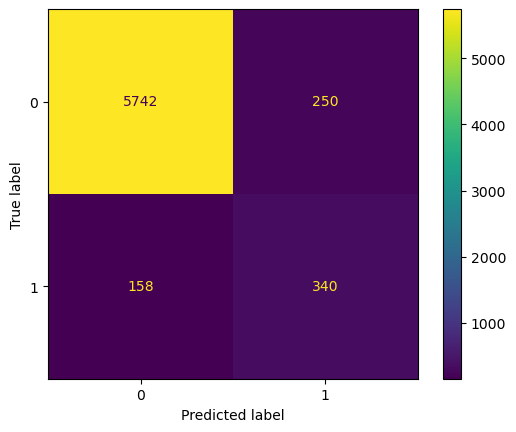

In [100]:
cm = confusion_matrix(y_test, results["y_pred"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()

In [101]:
# LOOK AT AUC

from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

# Compute AUC-ROC
auc_roc = roc_auc_score(results["y_test"], results["y_pred"])

# Displaying the results
print(f"AUC is: {auc_roc:}")


AUC is: 0.8205043136497929


In [91]:
# Initializing and training the logistic regression model
model = LogisticRegression(random_state=2, max_iter=5000, penalty='l2', C=1.0)
model.fit(X_train, y_train)

# Adding a constant to the features for statsmodels
X_train_stats = sm.add_constant(X_train)

# Fitting logistic regression model using statsmodels
logit_model = sm.Logit(y_train, X_train_stats)
result = logit_model.fit()

# Displaying the summary with coefficients and p-values
print(result.summary())



C:\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


         Current function value: 0.148182
         Iterations: 35


C:\Anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:            tackle_prob   No. Observations:                42053
Model:                          Logit   Df Residuals:                    42021
Method:                           MLE   Df Model:                           31
Date:                Sat, 09 Dec 2023   Pseudo R-squ.:                  0.4567
Time:                        10:40:03   Log-Likelihood:                -6231.5
converged:                      False   LL-Null:                       -11469.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.9380   1.06e+06  -8.87e-07      1.000   -2.07e+06    2.07e+06
s_defense                     0.2927      0.016     18.307      0.000       0.261     

In [283]:
# Get the coefficients (weights) of the features
coefficients = model.coef_[0]

# Create a DataFrame to display feature names and their corresponding coefficients
feature_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Coefficient': coefficients
})

# Sort the DataFrame by absolute coefficient values to see the importance
feature_importance_df['AbsoluteCoefficient'] = feature_importance_df['Coefficient'].abs()
feature_importance_df = feature_importance_df.sort_values(by='AbsoluteCoefficient', ascending=False).drop('AbsoluteCoefficient', axis=1)

# Display the feature importance DataFrame
feature_importance_df

,Feature,Coefficient
10,assist,-24.308426
12,pff_missedTackle,-15.327823
14,game_rolling_tackle_ct,3.253316
16,game_rolling_missed_tackle_ct,-1.376095
11,forcedFumble,0.674809
33,position_group_defense_DB,0.592476
25,defense_win_prob,0.557555
35,position_group_defense_LB,-0.470234
49,offenseFormation_SHOTGUN,-0.436466
39,quarter_4,-0.399204


## CART

In [103]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [104]:
# Handling missing values if any
selected_data.dropna(inplace=True)

# Splitting the data into training and testing sets
train = selected_data[selected_data["week"] != 7]
test = selected_data[selected_data["week"] == 7]

# Remove week column
train = train.drop(columns=['week'])
test = test.drop(columns=['week'])


X_train = train.drop(columns=['tackle_prob'], axis=1)
X_test = test.drop(columns=['tackle_prob'], axis=1)
y_train = train['tackle_prob']
y_test = test['tackle_prob']

print("Number of tackles in test set:")
print(y_test.value_counts())

Number of tackles in test set:
0    5992
1     498
Name: tackle_prob, dtype: int64


In [105]:
# Initialize and train the CART model
cart_model = DecisionTreeClassifier(random_state=2)
cart_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=2)

In [106]:
# Extract playId and gameId for week 7 to later find player with highest prob of tackle
defensive_players_week7 = defensive_players[defensive_players['week'] == 7][['gameId', 'playId']]

# Concatenate X_test and defensive_players_week7ii
results = X_test.copy()
results = pd.concat([results, defensive_players_week7], axis=1)

# Making predictions on the test set
results["y_test"] = y_test
results['y_prob'] = cart_model.predict_proba(X_test)[:, 1]
results["y_prob_rank"] = results.groupby(by=(['playId','gameId']))['y_prob'].rank(ascending=False)
results["y_pred"] = np.where(results["y_prob_rank"] == 1, 1, 0)

# Evaluating the model
accuracy = accuracy_score(y_test, results["y_pred"])
classification_report_result = classification_report(y_test, results["y_pred"])

# Displaying the results
print(f"Accuracy: {accuracy:}")
print("Classification Report:\n", classification_report_result)

Accuracy: 0.9340523882896764
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96      5992
           1       0.62      0.36      0.46       498

    accuracy                           0.93      6490
   macro avg       0.78      0.67      0.71      6490
weighted avg       0.92      0.93      0.93      6490



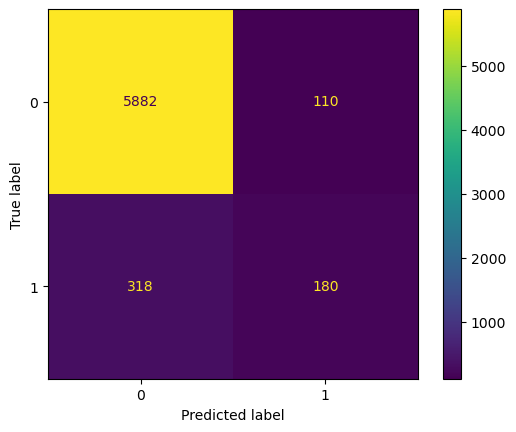

In [107]:
cm = confusion_matrix(y_test, results["y_pred"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()

In [108]:
# LOOK AT AUC

# Compute AUC-ROC
auc_roc = roc_auc_score(results["y_test"], results["y_pred"])

# Displaying the results
print(f"AUC is: {auc_roc:}")


AUC is: 0.6715439863593224


In [30]:
# Adding a constant to the features for statsmodels
X_train_stats = sm.add_constant(X_train)

# Fitting logistic regression model using statsmodels
logit_model = sm.Logit(y_train, X_train_stats)
result = logit_model.fit()

# Displaying the summary with coefficients and p-values
print(result.summary())

C:\Anaconda\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Anaconda\Lib\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


         Current function value: inf
         Iterations: 35


LinAlgError: Singular matrix

## Random Forest

In [64]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold

from sklearn.metrics import accuracy_score

In [32]:
# Handling missing values if any
selected_data.dropna(inplace=True)

# Splitting the data into training and testing sets
train = selected_data[selected_data["week"] != 7]
test = selected_data[selected_data["week"] == 7]

# Remove week column
train = train.drop(columns=['week'])
test = test.drop(columns=['week'])


X_train = train.drop(columns=['tackle_prob'], axis=1)
X_test = test.drop(columns=['tackle_prob'], axis=1)
y_train = train['tackle_prob']
y_test = test['tackle_prob']

print("Number of tackles in test set:")
print(y_test.value_counts())

Number of tackles in test set:
0    5992
1     498
Name: tackle_prob, dtype: int64


In [42]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the Random Forest classifier on the training data
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [49]:
# Extract playId and gameId for week 7 to later find player with highest prob of tackle
defensive_players_week7 = defensive_players[defensive_players['week'] == 7][['gameId', 'playId']]

# Concatenate X_test and defensive_players_week7ii
results = X_test.copy()
results = pd.concat([results, defensive_players_week7], axis=1)

# Making predictions on the test set
results["y_test"] = y_test
results['y_prob'] = rf_classifier.predict_proba(X_test)[:,1]
results["y_prob_rank"] = results.groupby(by=(['playId','gameId']))['y_prob'].rank(ascending=False)
results["y_pred"] = np.where(results["y_prob_rank"] == 1, 1, 0)

# Evaluating the model
accuracy = accuracy_score(y_test, results["y_pred"])
classification_report_result = classification_report(y_test, results["y_pred"])

# Displaying the results
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report_result)

Accuracy: 0.9349768875192604
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96      5992
           1       0.57      0.66      0.61       498

    accuracy                           0.93      6490
   macro avg       0.77      0.81      0.79      6490
weighted avg       0.94      0.93      0.94      6490



In [56]:
results[['playId', 'y_prob',"y_pred", 'y_test']].head(50)

,playId,y_prob,y_pred,y_test
6336,222,0.00,0,0
6337,222,0.00,0,0
6338,222,0.03,0,0
6339,222,0.87,1,0
6340,222,0.00,0,0
6341,222,0.05,0,0
6342,222,0.24,0,0
6343,222,0.01,0,0
6344,222,0.01,0,0
6345,222,0.00,0,0


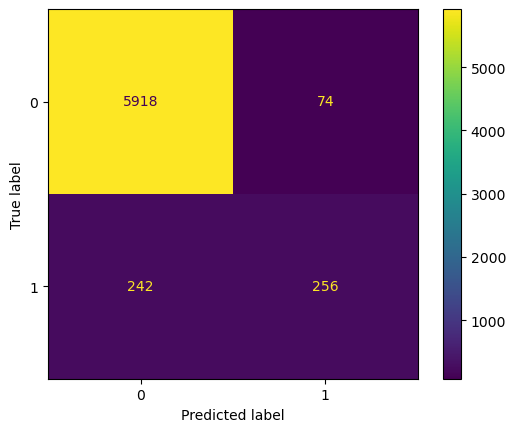

In [47]:
cm = confusion_matrix(y_test, results["y_pred"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()

In [45]:
# Compute AUC-ROC
auc_roc = roc_auc_score(results["y_test"], results["y_pred"])

# Displaying the results
print(f"AUC is: {auc_roc:.4f}")

AUC is: 0.7509


### Random Forest - Hyperparameter Tuning

In [95]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier

# # Define the parameter grid
# param_grid = {
#     'n_estimators': [50, 100, 150],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt', 'log2']
# }

# # Initialize the Random Forest classifier
# rf_classifier = RandomForestClassifier(random_state=42)

# # Use GridSearchCV to find the best hyperparameters
# grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train, y_train)

In [96]:
# # Get the best hyperparameters and the best model
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_

# # Train the best model on the entire training set
# best_model.fit(X_train, y_train)

In [65]:
# Best hyperparameters
best_max_depth = None
best_max_features = 'sqrt'
best_min_samples_leaf = 1
best_min_samples_split = 5
best_n_estimators = 150

# Initialize the Random Forest classifier with the best hyperparameters
best_rf_classifier = RandomForestClassifier(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf,
    max_features=best_max_features,
    random_state=42
)

# Fit the Random Forest
best_rf_classifier.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=5, n_estimators=150, random_state=42)

In [66]:
# Extract playId and gameId for week 7 to later find player with highest prob of tackle
defensive_players_week7 = defensive_players[defensive_players['week'] == 7][['gameId', 'playId']]

# Concatenate X_test and defensive_players_week7ii
results = X_test.copy()
results = pd.concat([results, defensive_players_week7], axis=1)

# Making predictions on the test set
results["y_test"] = y_test
results['y_prob'] = best_rf_classifier.predict_proba(X_test)[:, 1]
results["y_prob_rank"] = results.groupby(by=(['playId','gameId']))['y_prob'].rank(ascending=False)
results["y_pred"] = np.where(results["y_prob_rank"] == 1, 1, 0)

# Evaluating the model
accuracy = accuracy_score(y_test, results["y_pred"])
classification_report_result = classification_report(y_test, results["y_pred"])

# Displaying the results
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report_result)

Accuracy: 0.9355932203389831
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96      5992
           1       0.57      0.67      0.62       498

    accuracy                           0.94      6490
   macro avg       0.77      0.82      0.79      6490
weighted avg       0.94      0.94      0.94      6490



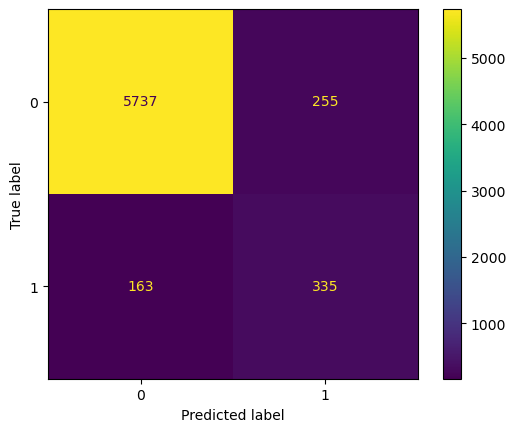

In [67]:
cm = confusion_matrix(y_test, results["y_pred"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()

In [68]:
# Compute AUC-ROC
auc_roc = roc_auc_score(results["y_test"], results["y_pred"])

# Displaying the results
print(f"AUC is: {auc_roc:.4f}")

AUC is: 0.8151


Top Features:
                        Feature  Importance
22                   dist_to_bc    0.216587
23                   rank_to_bc    0.198227
0                     s_defense    0.054363
5                weight_defense    0.036261
1                     a_defense    0.031064
3                   dir_defense    0.031012
2                     o_defense    0.030513
13                    s_offense    0.029972
8                    passLength    0.029680
14                    a_offense    0.027529
15                    o_offense    0.027279
16                  dir_offense    0.026531
21             defense_win_prob    0.025968
7                time_remaining    0.025276
17               weight_offense    0.022027
12             pff_missedTackle    0.019355
10                       assist    0.017255
4        height_in_inch_defense    0.016896
6                     yardsToGo    0.015698
18       height_in_inch_offense    0.015429
20                defense_score    0.015353
19                

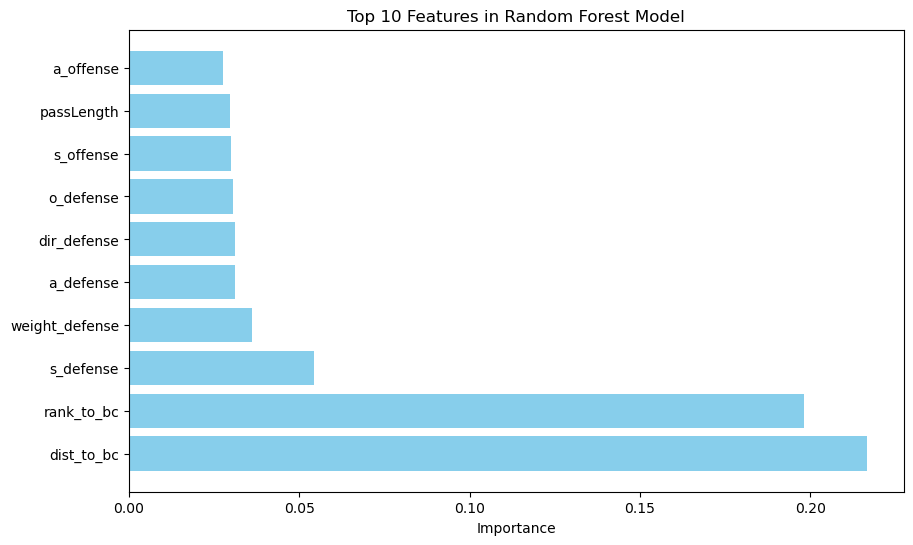

In [71]:
# Get feature importances
feature_importances = best_rf_classifier.feature_importances_

# Create a DataFrame to better visualize the results
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top features
print("Top Features:")
print(feature_importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Features in Random Forest Model')
plt.show()

### Random Forest - Drop insignificant features

Accuracy: 0.936517719568567
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97      5992
           1       0.57      0.68      0.62       498

    accuracy                           0.94      6490
   macro avg       0.77      0.82      0.79      6490
weighted avg       0.94      0.94      0.94      6490

AUC is: 0.8183


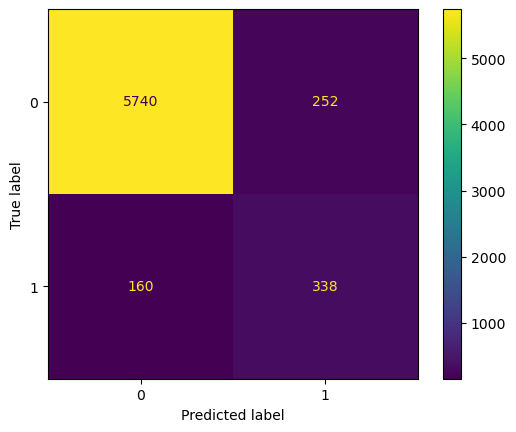

In [72]:
# DROPPING INSIGNIFICANT FEATURES

# Set Threshold
threshold = 0.01

# Identify non-significant features
non_significant_features = feature_importance_df[feature_importance_df['Importance'] < threshold]['Feature']

# Drop non-significant features from the training and test sets
X_train_reduced = X_train.drop(columns=non_significant_features)
X_test_reduced = X_test.drop(columns=non_significant_features)

# Retrain the model on the reduced feature set
rf_classifier_reduced = RandomForestClassifier(
    n_estimators=150,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42
)

rf_classifier_reduced.fit(X_train_reduced, y_train)

# # Evaluate the model's performance on the test set
# accuracy_reduced = rf_classifier_reduced.score(X_test_reduced, y_test)


# Extract playId and gameId for week 7 to later find player with highest prob of tackle
defensive_players_week7 = defensive_players[defensive_players['week'] == 7][['gameId', 'playId']]

# Concatenate X_test and defensive_players_week7ii
results = X_test.copy()
results_drop = results.drop(columns=non_significant_features)
results = pd.concat([results_drop, defensive_players_week7], axis=1)

# Making predictions on the test set
results["y_test"] = y_test
results['y_prob'] = rf_classifier_reduced.predict_proba(results_drop)[:, 1]
results["y_prob_rank"] = results.groupby(by=(['playId','gameId']))['y_prob'].rank(ascending=False)
results["y_pred"] = np.where(results["y_prob_rank"] == 1, 1, 0)

# Evaluating the model
accuracy = accuracy_score(y_test, results["y_pred"])
classification_report_result = classification_report(y_test, results["y_pred"])

# Displaying the results
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report_result)

cm = confusion_matrix(y_test, results["y_pred"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()

# Compute AUC-ROC
auc_roc = roc_auc_score(results["y_test"], results["y_pred"])

# Displaying the results
print(f"AUC is: {auc_roc:.4f}")


# XGBoost

### XGBoost - Raw

In [7]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [8]:
# Handling missing values if any
selected_data.dropna(inplace=True)

# Splitting the data into training and testing sets
train = selected_data[selected_data["week"] != 7]
test = selected_data[selected_data["week"] == 7]

# Remove week column
train = train.drop(columns=['week'])
test = test.drop(columns=['week'])


X_train = train.drop(columns=['tackle_prob'], axis=1)
X_test = test.drop(columns=['tackle_prob'], axis=1)
y_train = train['tackle_prob']
y_test = test['tackle_prob']

print("Number of tackles in test set:")
print(y_test.value_counts())

Number of tackles in test set:
0    5992
1     498
Name: tackle_prob, dtype: int64


In [11]:
# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

# Train the XGBoost classifier on the training data
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [12]:
# Extract playId and gameId for week 7 to later find player with highest prob of tackle
defensive_players_week7 = defensive_players[defensive_players['week'] == 7][['gameId', 'playId']]

# Concatenate X_test and defensive_players_week7ii
results = X_test.copy()
results = pd.concat([results, defensive_players_week7], axis=1)

# Making predictions on the test set
results["y_test"] = y_test
results['y_prob'] = xgb_classifier.predict_proba(X_test)[:, 1]
results["y_prob_rank"] = results.groupby(by=(['playId','gameId']))['y_prob'].rank(ascending=False)
results["y_pred"] = np.where(results["y_prob_rank"] == 1, 1, 0)

# Evaluating the model
accuracy = accuracy_score(y_test, results["y_pred"])
classification_report_result = classification_report(y_test, results["y_pred"])

# Displaying the results
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report_result)

Accuracy: 0.9417565485362096
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97      5992
           1       0.60      0.71      0.65       498

    accuracy                           0.94      6490
   macro avg       0.79      0.84      0.81      6490
weighted avg       0.95      0.94      0.94      6490



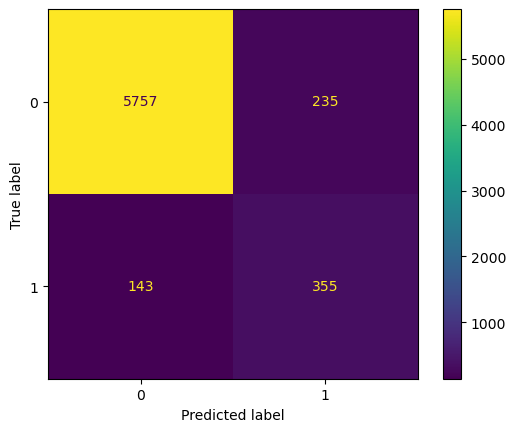

In [16]:
cm = confusion_matrix(y_test, results["y_pred"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()

In [17]:
# Compute AUC-ROC
auc_roc = roc_auc_score(results["y_test"], results["y_pred"])

# Displaying the results
print(f"AUC is: {auc_roc:.4f}")

AUC is: 0.8368


### XGBoost - Hyperparameter Tuning - Simple (best)

In [20]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# param_grid = {
#     'learning_rate': [0.01, 0.1],
#     'n_estimators': [50, 100],
#     'max_depth': [3, 4],
#     'min_child_weight': [1, 3],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
#     'gamma': [0, 0.1]
# }

# # Initialize the XGBoost classifier
# xgb_classifier = xgb.XGBClassifier(seed=42)

# # Use GridSearchCV to find the best hyperparameters
# grid_search = GridSearchCV(xgb_classifier, param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.8, 1.0], 'gamma': [0, 0.1],
                         'learning_rate': [0.01, 0.1], 'max_depth': [3, 4],
                         'min_child_weight': [1, 3], 'n_estimators': [50, 100],
                         'subsample': [0.8, 1.0]},
             scoring='accuracy')

In [21]:
# Get the best hyperparameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Hyperparameters:", best_params)

# Train the best model on the entire training set
best_model.fit(X_train, y_train)

Best Hyperparameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [22]:
# Extract playId and gameId for week 7 to later find player with highest prob of tackle
defensive_players_week7 = defensive_players[defensive_players['week'] == 7][['gameId', 'playId']]

# Concatenate X_test and defensive_players_week7ii
results = X_test.copy()
results = pd.concat([results, defensive_players_week7], axis=1)

# Making predictions on the test set
results["y_test"] = y_test
results['y_prob'] = best_model.predict_proba(X_test)[:, 1]
results["y_prob_rank"] = results.groupby(by=(['playId','gameId']))['y_prob'].rank(ascending=False)
results["y_pred"] = np.where(results["y_prob_rank"] == 1, 1, 0)

# Evaluating the model
accuracy = accuracy_score(y_test, results["y_pred"])
classification_report_result = classification_report(y_test, results["y_pred"])

# Displaying the results
print(f"Accuracy: {accuracy}")
print("Best Hyperparameters:", best_params)
print("Classification Report:\n", classification_report_result)

Accuracy: 0.9436055469953775
Best Hyperparameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97      5992
           1       0.61      0.72      0.66       498

    accuracy                           0.94      6490
   macro avg       0.79      0.84      0.82      6490
weighted avg       0.95      0.94      0.95      6490



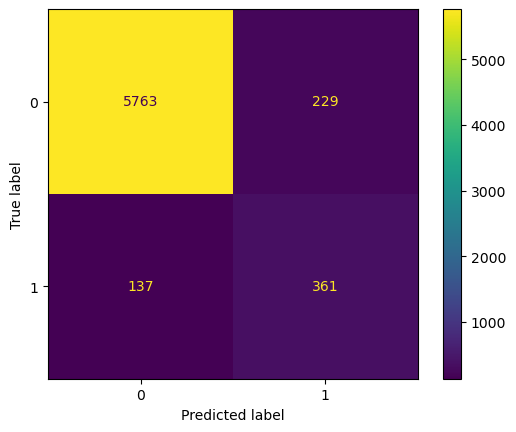

In [23]:
cm = confusion_matrix(y_test, results["y_pred"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()

In [24]:
# Compute AUC-ROC
auc_roc = roc_auc_score(results["y_test"], results["y_pred"])

# Displaying the results
print(f"AUC is: {auc_roc:.4f}")

AUC is: 0.8433


### XGBoost - hyperparameter tuning - Advanced

In [25]:
# param_grid = {
#     'learning_rate': [0.01, 0.1, 0.2],
#     'n_estimators': [50, 100, 150],
#     'max_depth': [3, 4, 5],
#     'min_child_weight': [1, 3, 5],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0],
#     'gamma': [0, 0.1, 0.2]
# }

# # Initialize the XGBoost classifier
# xgb_classifier = xgb.XGBClassifier(seed=42)

# # Use GridSearchCV to find the best hyperparameters
# grid_search = GridSearchCV(xgb_classifier, param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [50, 100, 150],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='accuracy')

In [26]:
# Get the best hyperparameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Hyperparameters:", best_params)

# Train the best model on the entire training set
best_model.fit(X_train, y_train)

Best Hyperparameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 150, 'subsample': 1.0}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [27]:
# Extract playId and gameId for week 7 to later find player with highest prob of tackle
defensive_players_week7 = defensive_players[defensive_players['week'] == 7][['gameId', 'playId']]

# Concatenate X_test and defensive_players_week7ii
results = X_test.copy()
results = pd.concat([results, defensive_players_week7], axis=1)

# Making predictions on the test set
results["y_test"] = y_test
results['y_prob'] = best_model.predict_proba(X_test)[:, 1]
results["y_prob_rank"] = results.groupby(by=(['playId','gameId']))['y_prob'].rank(ascending=False)
results["y_pred"] = np.where(results["y_prob_rank"] == 1, 1, 0)

# Evaluating the model
accuracy = accuracy_score(y_test, results["y_pred"])
classification_report_result = classification_report(y_test, results["y_pred"])

# Displaying the results
print(f"Accuracy: {accuracy}")
print("Best Hyperparameters:", best_params)
print("Classification Report:\n", classification_report_result)

Accuracy: 0.9423728813559322
Best Hyperparameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 150, 'subsample': 1.0}
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97      5992
           1       0.61      0.72      0.66       498

    accuracy                           0.94      6490
   macro avg       0.79      0.84      0.81      6490
weighted avg       0.95      0.94      0.94      6490



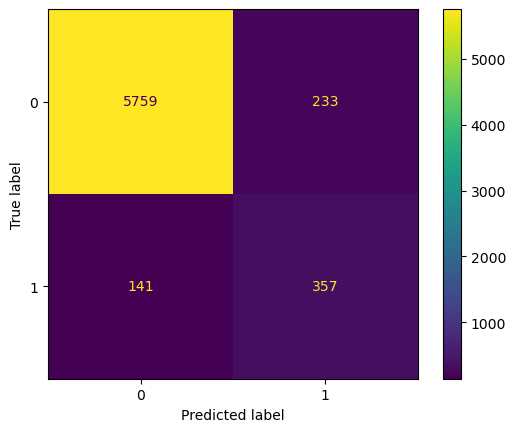

In [28]:
cm = confusion_matrix(y_test, results["y_pred"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()

In [29]:
# Compute AUC-ROC
auc_roc = roc_auc_score(results["y_test"], results["y_pred"])

# Displaying the results
print(f"AUC is: {auc_roc:.4f}")

AUC is: 0.8390


#### Plugging in directly

In [54]:
# # Best hyperparameters
# best_max_depth = None
# best_max_features = 'sqrt'
# best_min_samples_leaf = 1
# best_min_samples_split = 5
# best_n_estimators = 150

# # Best hyperparameters more
# best_xgb_classifier = xgb.XGBClassifier(
#     colsample_bytree=0.8,
#     gamma=0.1,
#     learning_rate=0.2,
#     max_depth=4,
#     min_child_weight=1,
#     n_estimators=150,
#     subsample=1.0,
#     random_state=42
# )

# Best hyperparameters short
# best_xgb_classifier = xgb.XGBClassifier(
#     colsample_bytree=1,
#     gamma=0,
#     learning_rate=0.1,
#     max_depth=4,
#     min_child_weight=1,
#     n_estimators=100,
#     subsample=0.8,
#     random_state=42
# )

# Initialize with best hyperparameters
best_xgb_classifier = xgb.XGBClassifier(
    colsample_bytree=1,
    gamma=0,
    learning_rate=0.1,
    max_depth=4,
    min_child_weight=1,
    n_estimators=200,
    subsample=1.0,
    random_state=42
)

# Fit the Random Forest
best_xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

Accuracy: 0.9429892141756548
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97      5992
           1       0.61      0.72      0.66       498

    accuracy                           0.94      6490
   macro avg       0.79      0.84      0.81      6490
weighted avg       0.95      0.94      0.95      6490

AUC is: 0.8412


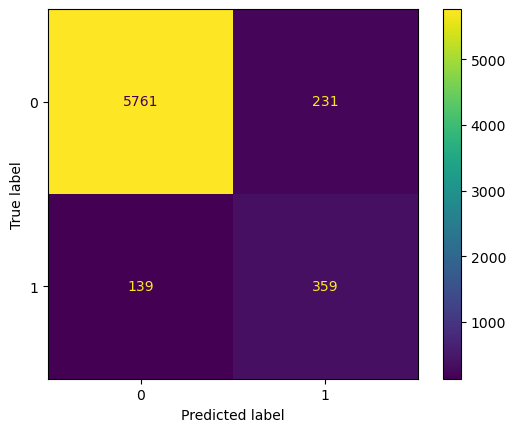

In [55]:
# Extract playId and gameId for week 7 to later find player with highest prob of tackle
defensive_players_week7 = defensive_players[defensive_players['week'] == 7][['gameId', 'playId']]

# Concatenate X_test and defensive_players_week7ii
results = X_test.copy()
results = pd.concat([results, defensive_players_week7], axis=1)

# Making predictions on the test set
results["y_test"] = y_test
results['y_prob'] = best_xgb_classifier.predict_proba(X_test)[:, 1]
results["y_prob_rank"] = results.groupby(by=(['playId','gameId']))['y_prob'].rank(ascending=False)
results["y_pred"] = np.where(results["y_prob_rank"] == 1, 1, 0)

# Evaluating the model
accuracy = accuracy_score(y_test, results["y_pred"])
classification_report_result = classification_report(y_test, results["y_pred"])

# Displaying the results
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report_result)

cm = confusion_matrix(y_test, results["y_pred"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()

# Compute AUC-ROC
auc_roc = roc_auc_score(results["y_test"], results["y_pred"])

# Displaying the results
print(f"AUC is: {auc_roc:.4f}")

# Ensemble - XGBoost and RF

In [ ]:
# Predicts 1 if RF predicts true negative (0) and XGBoost predicts True positive (1)

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix


combined_predictions = np.logical_and(rf_predictions == 0, xgb_predictions == 1)

# Evaluate the combined model
combined_accuracy = accuracy_score(y_test, combined_predictions)
combined_auc = roc_auc_score(y_test, combined_predictions)
combined_conf_matrix = confusion_matrix(y_test, combined_predictions)

# Print results
print(f"Combined Model Accuracy: {combined_accuracy:.4f}")
print(f"Combined Model AUC: {combined_auc:.4f}")
print("Combined Model Confusion Matrix:")
print(combined_conf_matrix)

In [ ]:
# Create individual models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = XGBClassifier(n_estimators=100, random_state=42)

# Create a voting classifier
ensemble_model = VotingClassifier(estimators=[
    ('Random Forest', rf_model),
    ('XGBoost', xgb_model)
], voting='soft')  # 'soft' enables probability averaging

# Fit the ensemble model
ensemble_model.fit(X_train, y_train)

# Make predictions
y_pred = ensemble_model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Ensemble Model Accuracy: {accuracy}')

# Other

In [109]:
from tabulate import tabulate

# Data
data = [
    ["Logistic", "", 0.9371, 0.8205, 5742, 340],
    ["CART", "", 0.9341, 0.6715, 5882, 180],
    ["RF", "Raw", 0.9349, 0.7509, 5918, 256],
    ["RF", "Tuned", 0.9356, 0.8151, 5737, 335],
    ["RF", "Tuned and drop non-sig", 0.9365, 0.8183, 5740, 338],
    ["XGBoost", "Raw", 0.9418, 0.8368, 5757, 355],
    ["XGBoost", "Tuned simple", 0.9436, 0.8433, 5763, 361],
    ["XGBoost", "Tuned complex", 0.9424, 0.8390, 5759, 357],
]

# Headers
headers = ["Model", "Notes", "Accuracy", "AUC", "TN", "TP"]

# Create and print the table
table = tabulate(data, headers, tablefmt="fancy_grid")
print(table)

╒══════════╤════════════════════════╤════════════╤════════╤══════╤══════╕
│ Model    │ Notes                  │   Accuracy │    AUC │   TN │   TP │
╞══════════╪════════════════════════╪════════════╪════════╪══════╪══════╡
│ Logistic │                        │     0.9371 │ 0.8205 │ 5742 │  340 │
├──────────┼────────────────────────┼────────────┼────────┼──────┼──────┤
│ CART     │                        │     0.9341 │ 0.6715 │ 5882 │  180 │
├──────────┼────────────────────────┼────────────┼────────┼──────┼──────┤
│ RF       │ Raw                    │     0.9349 │ 0.7509 │ 5918 │  256 │
├──────────┼────────────────────────┼────────────┼────────┼──────┼──────┤
│ RF       │ Tuned                  │     0.9356 │ 0.8151 │ 5737 │  335 │
├──────────┼────────────────────────┼────────────┼────────┼──────┼──────┤
│ RF       │ Tuned and drop non-sig │     0.9365 │ 0.8183 │ 5740 │  338 │
├──────────┼────────────────────────┼────────────┼────────┼──────┼──────┤
│ XGBoost  │ Raw                    │ 

In [317]:
pd.set_option('display.max_rows', None)
defensive_players[defensive_players['nflId_defense']==38577.0][['gameId', 'playId','nflId_defense','season_rolling_tackle_ct','season_rolling_missed_tackle_ct', 'game_rolling_tackle_ct', 'game_rolling_missed_tackle_ct', 'tackle_prob']]

,gameId,playId,nflId_defense,season_rolling_tackle_ct,season_rolling_missed_tackle_ct,game_rolling_tackle_ct,game_rolling_missed_tackle_ct,tackle_prob
0,2022090800,56,38577.0,0.0,0.0,0.0,0.0,0
11,2022090800,122,38577.0,1.0,0.0,1.0,0.0,1
22,2022090800,167,38577.0,0.0,0.0,0.0,0.0,0
33,2022090800,212,38577.0,2.0,0.0,2.0,0.0,1
44,2022090800,236,38577.0,0.0,0.0,0.0,0.0,0
55,2022090800,569,38577.0,0.0,0.0,0.0,0.0,0
66,2022090800,593,38577.0,0.0,0.0,0.0,0.0,0
77,2022090800,617,38577.0,0.0,0.0,0.0,0.0,0
88,2022090800,646,38577.0,0.0,0.0,0.0,0.0,0
99,2022090800,692,38577.0,3.0,0.0,3.0,0.0,1
